In [1]:
import numpy as np
from model_vanilla_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/zoom_aug_vanillaG_lr0.0002/checkpoint"
sample_dir = "./out/zoom_aug_vanillaG_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

zoom aug is disabled
loading mnist without augmenting ...
 [*] Reading checkpoints... ./out/zoom_aug_vanillaG_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/zoom_aug_vanillaG_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


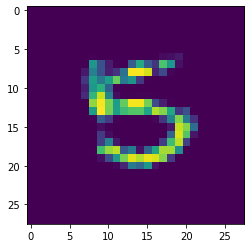

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder-tf.log(alpha)*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    
    if alpha == 1:
        return outputs_zs, mask_fn
    
    new_size = int(alpha*img_size)

    ## crop
    if alpha < 1:
        output_cropped = outputs_zs[:,img_size//2-new_size//2:img_size//2+new_size//2, img_size//2-new_size//2:img_size//2+new_size//2,:]
        mask_cropped = mask_fn
    ## padding
    else:
        output_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        mask_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        output_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = outputs_zs 
        mask_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = mask_fn
    
    ## Resize
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.resize(output_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.resize(mask_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        
    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
    
    if show_img:
        print('Target image:')
        imshow_unscaled(target_fn)
    if show_mask:
        print('Target mask:')
        imshow_unscaled(mask_out)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/zoom_NoAug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = np.random.uniform(0.6, 1.) 
            else:
                alpha_val = np.random.uniform(1., 1.67) 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-12 17:55:06,177 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.3711693286895752, 0, 0, 0.12209175527095795, 0.6472203579107133
2019-09-12 17:55:06,185 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006493330001831055, 0, 10, 0.1073637381196022, 1.3268087896318332
2019-09-12 17:55:06,193 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007473468780517578, 0, 20, 0.009669007733464241, 0.9815755022674948
2019-09-12 17:55:06,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006551027297973633, 0, 30, 0.15028612315654755, 0.6127145854473951
2019-09-12 17:55:06,208 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065135955810546875, 0, 40, 0.08250095695257187, 0.7252242541560228
2019-09-12 17:55:06,215 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006480216979980469, 0, 50, 0.1303601711988449, 1.4911149630515041
2019-09-12 17:55:06,222 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006554126739501953, 0, 60, 0.020855875685811043, 1.044392562618181
2019-09-12 17:55:06,231 [MainThread  

2019-09-12 17:55:06,674 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066411495208740234, 0, 590, 0.015249652788043022, 1.2202684651671067
2019-09-12 17:55:06,681 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006629467010498047, 0, 600, 0.07086896151304245, 0.7805792434199624
2019-09-12 17:55:06,689 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067861080169677734, 0, 610, 0.015429445542395115, 0.8725510782455248
2019-09-12 17:55:06,696 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006287097930908203, 0, 620, 0.07542628794908524, 0.7048058712112911
2019-09-12 17:55:06,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057909488677978516, 0, 630, 0.023858090862631798, 1.3044461411665558
2019-09-12 17:55:06,710 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006174802780151367, 0, 640, 0.008888284675776958, 0.9858461789885951
2019-09-12 17:55:06,717 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00660395622253418, 0, 650, 0.017185205593705177, 1.1099296525861753
2019-09-12 17:55:06,

2019-09-12 17:55:07,095 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005808830261230469, 0, 1180, 0.03963610902428627, 1.5331692076411712
2019-09-12 17:55:07,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005421876907348633, 0, 1190, 0.051368728280067444, 0.6494968020849599
2019-09-12 17:55:07,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005337238311767578, 0, 1200, 0.021441573277115822, 0.8209370522163353
2019-09-12 17:55:07,113 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00506281852722168, 0, 1210, 0.12622235715389252, 0.6233572929166648
2019-09-12 17:55:07,119 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005711555480957031, 0, 1220, 0.05540623515844345, 1.57419737016607
2019-09-12 17:55:07,125 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005307674407958984, 0, 1230, 0.05282467603683472, 1.6439670463345952
2019-09-12 17:55:07,131 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005644559860229492, 0, 1240, 0.055087022483348846, 0.6597351612040582
2019-09-12 17:55:07,

2019-09-12 17:55:07,472 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011075019836425781, 0, 1770, 0.038992177695035934, 0.8428822379140855
2019-09-12 17:55:07,479 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058879852294921875, 0, 1780, 0.06407994776964188, 0.6825605947284662
2019-09-12 17:55:07,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058286190032958984, 0, 1790, 0.03667902201414108, 0.7670089646136529
2019-09-12 17:55:07,492 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006041049957275391, 0, 1800, 0.016536977142095566, 0.863003781286829
2019-09-12 17:55:07,498 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005245685577392578, 0, 1810, 0.04192996397614479, 1.2959312969680306
2019-09-12 17:55:07,504 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005434989929199219, 0, 1820, 0.04317963495850563, 1.5373217599270532
2019-09-12 17:55:07,510 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00540924072265625, 0, 1830, 0.03048284910619259, 1.4848759173272734
2019-09-12 17:55:0

2019-09-12 17:55:07,831 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00553584098815918, 0, 2350, 0.012449451722204685, 0.9144075648181118
2019-09-12 17:55:07,837 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005436897277832031, 0, 2360, 0.045073941349983215, 1.5991272355417807
2019-09-12 17:55:07,843 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005238533020019531, 0, 2370, 0.014985754154622555, 1.16062100529957
2019-09-12 17:55:07,849 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005014657974243164, 0, 2380, 0.05921555310487747, 0.7578807457782717
2019-09-12 17:55:07,855 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0055391788482666016, 0, 2390, 0.03555753827095032, 0.8391025818442462
2019-09-12 17:55:07,860 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004920244216918945, 0, 2400, 0.04866796359419823, 0.726242052127309
2019-09-12 17:55:07,866 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0048503875732421875, 0, 2410, 0.04251449182629585, 1.5049889813230697
2019-09-12 17:55:07

2019-09-12 17:55:08,208 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006483554840087891, 0, 2940, 0.07616256177425385, 0.6872487112630923
2019-09-12 17:55:08,215 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058062076568603516, 0, 2950, 0.021248549222946167, 1.2125382016781767
2019-09-12 17:55:08,221 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005808115005493164, 0, 2960, 0.022189339622855186, 1.300622902425551
2019-09-12 17:55:08,229 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007671356201171875, 0, 2970, 0.05107608810067177, 1.6279332821414385
2019-09-12 17:55:08,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00515294075012207, 0, 2980, 0.011110695078969002, 1.21838684135215
2019-09-12 17:55:08,242 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006648063659667969, 0, 2990, 0.06033288314938545, 1.623472387401799
2019-09-12 17:55:08,249 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059185028076171875, 0, 3000, 0.04355762526392937, 1.4902756859984794
Loss: [0.00475909804

2019-09-12 17:55:08,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005316972732543945, 0, 3520, 0.006297632586210966, 0.9657366842316165
2019-09-12 17:55:08,632 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00529026985168457, 0, 3530, 0.07677382230758667, 0.6652092508116177
2019-09-12 17:55:08,639 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00578761100769043, 0, 3540, 0.012544806115329266, 0.8952734564264899
2019-09-12 17:55:08,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005630016326904297, 0, 3550, 0.0002454955829307437, 1.0110567285457048
2019-09-12 17:55:08,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057489871978759766, 0, 3560, 0.04132848232984543, 1.331762254980815
2019-09-12 17:55:08,658 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005587339401245117, 0, 3570, 0.05103563144803047, 1.4392274630850426
2019-09-12 17:55:08,664 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005421876907348633, 0, 3580, 0.029908467084169388, 1.2621997278884716
2019-09-12 17:55:

2019-09-12 17:55:08,995 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0053863525390625, 0, 4100, 0.03682841360569, 0.7790857776465773
2019-09-12 17:55:09,001 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005899906158447266, 0, 4110, 0.005568558815866709, 1.08959537562719
2019-09-12 17:55:09,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005563497543334961, 0, 4120, 0.02564268559217453, 1.3578517275010957
2019-09-12 17:55:09,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005553722381591797, 0, 4130, 0.02029818668961525, 1.2196663370742467
2019-09-12 17:55:09,019 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005156755447387695, 0, 4140, 0.03825243562459946, 1.50958987368152
2019-09-12 17:55:09,025 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00506281852722168, 0, 4150, 0.017045730724930763, 0.9267693137041914
2019-09-12 17:55:09,031 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0053331851959228516, 0, 4160, 0.02053644321858883, 0.8697373174475573
2019-09-12 17:55:09,036 [Ma

2019-09-12 17:55:09,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0049555301666259766, 0, 4690, 0.014426236972212791, 1.0622014420799604
2019-09-12 17:55:09,376 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006327390670776367, 0, 4700, 0.034384746104478836, 1.4667097428971803
2019-09-12 17:55:09,382 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004941463470458984, 0, 4710, 0.028829019516706467, 0.8387232184633848
2019-09-12 17:55:09,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0050508975982666016, 0, 4720, 0.02721472457051277, 1.2791075600160946
2019-09-12 17:55:09,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006829977035522461, 0, 4730, 0.037699952721595764, 0.7495060251505183
2019-09-12 17:55:09,400 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004915714263916016, 0, 4740, 0.04052002727985382, 0.7538428551147762
2019-09-12 17:55:09,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057621002197265625, 0, 4750, 0.05586205795407295, 1.6082168249793827
2019-09-12 17

2019-09-12 17:55:09,745 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004594326019287109, 0, 5270, 0.027089344337582588, 1.4580801053381993
2019-09-12 17:55:09,751 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005254983901977539, 0, 5280, 0.008328369818627834, 0.9544320718986937
2019-09-12 17:55:09,757 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0048329830169677734, 0, 5290, 0.04025135561823845, 0.782514164616594
2019-09-12 17:55:09,762 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0048198699951171875, 0, 5300, 0.0023244586773216724, 1.0352541526873429
2019-09-12 17:55:09,768 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00502467155456543, 0, 5310, 0.037794701755046844, 0.7965791654267109
2019-09-12 17:55:09,774 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005431413650512695, 0, 5320, 0.017500367015600204, 1.099729477190416
2019-09-12 17:55:09,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005291938781738281, 0, 5330, 0.03728996589779854, 0.7725187349123739
2019-09-12 17:5

2019-09-12 17:55:10,092 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004970073699951172, 0, 5860, 0.0668802559375763, 0.6584728265697791
2019-09-12 17:55:10,098 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004904508590698242, 0, 5870, 0.0026517952792346478, 1.0355551368796194
2019-09-12 17:55:10,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004898548126220703, 0, 5880, 0.06573548913002014, 0.6376758203584735
2019-09-12 17:55:10,109 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0051288604736328125, 0, 5890, 0.03268891200423241, 1.6511849298136427
2019-09-12 17:55:10,114 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005173921585083008, 0, 5900, 0.029186954721808434, 1.439909820549671
2019-09-12 17:55:10,120 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0050809383392333984, 0, 5910, 0.02202693372964859, 1.155436207552026
2019-09-12 17:55:10,126 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005126476287841797, 0, 5920, 0.01522722840309143, 1.0466410649925306
2019-09-12 17:55:1

2019-09-12 17:55:10,454 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0051364898681640625, 0, 6440, 0.013273919932544231, 0.8796647657335752
2019-09-12 17:55:10,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005003213882446289, 0, 6450, 0.06932802498340607, 0.6437752144197794
2019-09-12 17:55:10,466 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005061149597167969, 0, 6460, 0.12576209008693695, 0.6145888908910693
2019-09-12 17:55:10,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005299568176269531, 0, 6470, 0.024542327970266342, 1.4332216275230771
2019-09-12 17:55:10,477 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005252838134765625, 0, 6480, 0.02873874083161354, 0.7947297858042965
2019-09-12 17:55:10,483 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005117177963256836, 0, 6490, 0.0001855688460636884, 1.009986570802101
2019-09-12 17:55:10,489 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005522012710571289, 0, 6500, 0.018179690465331078, 0.8767363013901726
2019-09-12 17:5

2019-09-12 17:55:10,819 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0053691864013671875, 0, 7020, 0.01550291944295168, 1.0444334974699405
2019-09-12 17:55:10,826 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061435699462890625, 0, 7030, 0.023906342685222626, 1.2435080988860514
2019-09-12 17:55:10,832 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059413909912109375, 0, 7040, 0.027432091534137726, 0.772670687706577
2019-09-12 17:55:10,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007444143295288086, 0, 7050, 0.026605267077684402, 0.9042901014647206
2019-09-12 17:55:10,848 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006732940673828125, 0, 7060, 0.04776414483785629, 1.4400602420542912
2019-09-12 17:55:10,853 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005051612854003906, 0, 7070, 0.045184168964624405, 1.6397496112952021
2019-09-12 17:55:10,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005098819732666016, 0, 7080, 0.017712250351905823, 0.8654320348059331
2019-09-12 17

2019-09-12 17:55:11,200 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0049059391021728516, 0, 7610, 0.027901217341423035, 1.4279506798067318
2019-09-12 17:55:11,207 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005720376968383789, 0, 7620, 0.05440942943096161, 0.7022217758931852
2019-09-12 17:55:11,213 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005674600601196289, 0, 7630, 0.0009805664885789156, 1.0167050856382216
2019-09-12 17:55:11,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005762338638305664, 0, 7640, 0.00888112373650074, 1.1496917800406636
2019-09-12 17:55:11,226 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006134986877441406, 0, 7650, 0.023011203855276108, 0.8176436577182535
2019-09-12 17:55:11,233 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005731821060180664, 0, 7660, 0.019765520468354225, 1.045182133875549
2019-09-12 17:55:11,239 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005728006362915039, 0, 7670, 0.04293111339211464, 1.5983437680326316
2019-09-12 17:5

2019-09-12 17:55:11,574 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006076335906982422, 0, 8180, 0.01977595128118992, 1.2104827642376357
2019-09-12 17:55:11,581 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006134986877441406, 0, 8190, 0.03758307173848152, 1.5856349491057544
2019-09-12 17:55:11,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006359577178955078, 0, 8200, 0.00260567176155746, 1.027434950020936
2019-09-12 17:55:11,595 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005648136138916016, 0, 8210, 0.03693206608295441, 1.2949238717066958
2019-09-12 17:55:11,601 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005598545074462891, 0, 8220, 0.015029210597276688, 0.8706764093561998
2019-09-12 17:55:11,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005814075469970703, 0, 8230, 0.03844350203871727, 1.3020431451002523
2019-09-12 17:55:11,616 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008654356002807617, 0, 8240, 0.044421326369047165, 1.3276815964227655
2019-09-12 17:55:11

2019-09-12 17:55:11,979 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063817501068115234, 0, 8770, 0.026436062529683113, 1.3218215716566113
2019-09-12 17:55:11,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00681757926940918, 0, 8780, 7.75488224462606e-05, 1.0060633229403713
2019-09-12 17:55:11,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009622812271118164, 0, 8790, 0.024166448041796684, 1.2621306235890861
2019-09-12 17:55:12,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009119987487792969, 0, 8800, 0.018838796764612198, 0.8968759200956116
2019-09-12 17:55:12,013 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005779266357421875, 0, 8810, 0.03843575343489647, 0.7458513329699528
2019-09-12 17:55:12,019 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005651712417602539, 0, 8820, 0.020544009283185005, 1.3008978044298902
2019-09-12 17:55:12,025 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0052602291107177734, 0, 8830, 0.04015148803591728, 0.8174550860824141
2019-09-12 17:

2019-09-12 17:55:12,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00701451301574707, 0, 9340, 0.02054363116621971, 0.792987148230454
2019-09-12 17:55:12,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006945610046386719, 0, 9350, 0.026532234624028206, 1.355897723997297
2019-09-12 17:55:12,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060405731201171875, 0, 9360, 0.014058219268918037, 0.8889405686538987
2019-09-12 17:55:12,428 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007328987121582031, 0, 9370, 0.006113631650805473, 0.9678805442744295
2019-09-12 17:55:12,436 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007256031036376953, 0, 9380, 0.00868003536015749, 0.971588249489391
2019-09-12 17:55:12,444 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006911516189575195, 0, 9390, 0.008238138630986214, 1.081485016776088
2019-09-12 17:55:12,452 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006829500198364258, 0, 9400, 0.0229893010109663, 0.8699743867952445
2019-09-12 17:55:12,4

2019-09-12 17:55:12,848 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006783246994018555, 0, 9930, 0.020861517637968063, 1.3735883860990041
2019-09-12 17:55:12,855 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006578207015991211, 0, 9940, 0.06152678281068802, 1.6503128613905278
2019-09-12 17:55:12,864 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007381439208984375, 0, 9950, 0.01719384454190731, 1.2208966995311548
2019-09-12 17:55:12,873 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008311748504638672, 0, 9960, 0.04643397778272629, 0.6434750322242808
2019-09-12 17:55:12,881 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00743412971496582, 0, 9970, 0.023821275681257248, 0.8747939034412313
2019-09-12 17:55:12,888 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006538867950439453, 0, 9980, 0.02442971244454384, 0.9178056621467467
2019-09-12 17:55:12,895 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061187744140625, 0, 9990, 0.015493350103497505, 1.1210947651218552
2019-09-12 17:55:12,

2019-09-12 17:55:13,285 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007105112075805664, 0, 10500, 0.005922990385442972, 0.9691815207821507
2019-09-12 17:55:13,293 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007259845733642578, 0, 10510, 0.01383894681930542, 0.8931921254170618
2019-09-12 17:55:13,300 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00569605827331543, 0, 10520, 0.004682339262217283, 0.9552068837467786
2019-09-12 17:55:13,306 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005585193634033203, 0, 10530, 0.019342968240380287, 0.8142281206232818
2019-09-12 17:55:13,313 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005862712860107422, 0, 10540, 0.01811782270669937, 0.8895450905411606
2019-09-12 17:55:13,320 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064089298248291016, 0, 10550, 0.017899123951792717, 1.142545148554237
2019-09-12 17:55:13,327 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007072925567626953, 0, 10560, 0.007239919621497393, 0.9602739769981945
2019-09-1

2019-09-12 17:55:13,709 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0077495574951171875, 0, 11070, 0.03337330371141434, 1.4205071439649042
2019-09-12 17:55:13,717 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007205486297607422, 0, 11080, 0.01564658433198929, 0.9264021547601076
2019-09-12 17:55:13,724 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006333351135253906, 0, 11090, 0.018111152574419975, 0.8641950546834638
2019-09-12 17:55:13,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064318180084228516, 0, 11100, 0.008850866928696632, 1.1765645868838308
2019-09-12 17:55:13,738 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060956478118896484, 0, 11110, 0.012309273704886436, 0.9018253051492283
2019-09-12 17:55:13,747 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007509469985961914, 0, 11120, 0.053723786026239395, 1.639533620874251
2019-09-12 17:55:13,755 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007262229919433594, 0, 11130, 0.02124880440533161, 1.2404174397464107
2019-09

2019-09-12 17:55:14,159 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007344484329223633, 0, 11650, 0.02270355448126793, 0.924401999300871
2019-09-12 17:55:14,166 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005496501922607422, 0, 11660, 0.010807609185576439, 0.9896614391491505
2019-09-12 17:55:14,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006039142608642578, 0, 11670, 0.016179997473955154, 1.2200649070134642
2019-09-12 17:55:14,178 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005489826202392578, 0, 11680, 0.006262740585952997, 1.0819068009951727
2019-09-12 17:55:14,189 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01027226448059082, 0, 11690, 0.07163045555353165, 0.6239011593643412
2019-09-12 17:55:14,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00907754898071289, 0, 11700, 0.03561879321932793, 0.8515129865528007
2019-09-12 17:55:14,205 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005948781967163086, 0, 11710, 0.047182902693748474, 1.5901898844087032
2019-09-12 1

2019-09-12 17:55:14,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008052825927734375, 0, 12220, 0.04050668701529503, 1.6264541430858226
2019-09-12 17:55:14,602 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010173797607421875, 0, 12230, 0.024125879630446434, 0.9257834461733053
2019-09-12 17:55:14,610 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006665468215942383, 0, 12240, 0.03827643021941185, 0.6611334812855332
2019-09-12 17:55:14,618 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006677389144897461, 0, 12250, 0.005092817358672619, 1.0809197707730123
2019-09-12 17:55:14,625 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006579399108886719, 0, 12260, 0.03313493728637695, 1.574627277261461
2019-09-12 17:55:14,632 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006312370300292969, 0, 12270, 0.029724756255745888, 0.8051958488750606
2019-09-12 17:55:14,638 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005027055740356445, 0, 12280, 0.01003220770508051, 0.9873316324262
2019-09-12 17:

2019-09-12 17:55:15,033 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005532741546630859, 0, 12810, 0.02048441767692566, 1.2483254851987051
2019-09-12 17:55:15,040 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0056476593017578125, 0, 12820, 0.01908257231116295, 1.291163427570222
2019-09-12 17:55:15,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005650043487548828, 0, 12830, 0.03411685302853584, 1.3280760307345818
2019-09-12 17:55:15,052 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005486726760864258, 0, 12840, 0.016157979145646095, 0.8855569908907432
2019-09-12 17:55:15,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005712032318115234, 0, 12850, 0.09834881126880646, 0.6288925969116437
2019-09-12 17:55:15,065 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005831241607666016, 0, 12860, 0.06256379187107086, 0.733329893276724
2019-09-12 17:55:15,071 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005555629730224609, 0, 12870, 0.044560424983501434, 0.7765901311063912
2019-09-12 1

2019-09-12 17:55:15,434 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007327556610107422, 0, 13370, 0.000742763455491513, 1.0194497381359606
2019-09-12 17:55:15,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063457489013671875, 0, 13380, 0.00822517555207014, 0.952464380973945
2019-09-12 17:55:15,448 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00635981559753418, 0, 13390, 0.014130664058029652, 1.0940633176368004
2019-09-12 17:55:15,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006438255310058594, 0, 13400, 0.0370463952422142, 1.5348828139967088
2019-09-12 17:55:15,463 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067501068115234375, 0, 13410, 0.06055644154548645, 0.6865592018199727
2019-09-12 17:55:15,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066831111907958984, 0, 13420, 0.030426474288105965, 1.3975226000849172
2019-09-12 17:55:15,482 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011000394821166992, 0, 13430, 0.02838847041130066, 0.7251112929018722
2019-09-12

2019-09-12 17:55:15,873 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007460832595825195, 0, 13960, 0.045136984437704086, 0.7241094260470464
2019-09-12 17:55:15,880 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006936311721801758, 0, 13970, 0.10111832618713379, 0.6376450096147162
2019-09-12 17:55:15,887 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006117582321166992, 0, 13980, 0.042617250233888626, 1.572339262528399
2019-09-12 17:55:15,894 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00626683235168457, 0, 13990, 0.05101488158106804, 0.7305345479721486
2019-09-12 17:55:15,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005947589874267578, 0, 14000, 0.020264428108930588, 1.184458694103387
Loss: [0.004759098043345148, 0.0034526442034184582, 0.0030725722150987166, 0.003448864801612217, 0.0031658966906979915, 0.003474678588565439, 0.0032258264233823867, 0.003198589802952483, 0.0031340617896130425, 0.0031227291816030628, 0.003028613319096621, 0.0032545023943239357, 0.002832960089820

2019-09-12 17:55:16,300 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006743431091308594, 0, 14520, 0.026889478787779808, 0.8222984862610436
2019-09-12 17:55:16,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007784128189086914, 0, 14530, 0.05351625010371208, 1.495263387010304
2019-09-12 17:55:16,316 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006806850433349609, 0, 14540, 0.0365443117916584, 1.4174861637414118
2019-09-12 17:55:16,323 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006086111068725586, 0, 14550, 0.03371797502040863, 0.7348367835718936
2019-09-12 17:55:16,330 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006989955902099609, 0, 14560, 0.006658756639808416, 0.9440787784404898
2019-09-12 17:55:16,338 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007599592208862305, 0, 14570, 0.019028879702091217, 1.1405636604449831
2019-09-12 17:55:16,346 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006920576095581055, 0, 14580, 0.012963546440005302, 0.9913797680104964
2019-09-12 

2019-09-12 17:55:16,736 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006348609924316406, 0, 15080, 0.024288857355713844, 0.8019948476107428
2019-09-12 17:55:16,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006964445114135742, 0, 15090, 0.005945141427218914, 0.9612925891617534
2019-09-12 17:55:16,751 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006644487380981445, 0, 15100, 0.028119182214140892, 0.8055037455257945
2019-09-12 17:55:16,759 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006639719009399414, 0, 15110, 0.012446765787899494, 0.8589380364487106
2019-09-12 17:55:16,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006768465042114258, 0, 15120, 0.006006979383528233, 0.9850257045201668
2019-09-12 17:55:16,775 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007548332214355469, 0, 15130, 0.02958349883556366, 0.7882620982316519
2019-09-12 17:55:16,786 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010543107986450195, 0, 15140, 0.0029351755511015654, 1.0340318672261126
2019-0

2019-09-12 17:55:17,167 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006537199020385742, 0, 15660, 0.006687190383672714, 0.9385999810082094
2019-09-12 17:55:17,175 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071258544921875, 0, 15670, 0.037485044449567795, 0.6434960177230264
2019-09-12 17:55:17,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060939788818359375, 0, 15680, 0.04835066571831703, 0.7012668322279005
2019-09-12 17:55:17,188 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005869865417480469, 0, 15690, 0.029711775481700897, 1.303781631643632
2019-09-12 17:55:17,197 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008172035217285156, 0, 15700, 0.015147339552640915, 0.8801206211305193
2019-09-12 17:55:17,204 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006116628646850586, 0, 15710, 0.01699049398303032, 1.1581923689416254
2019-09-12 17:55:17,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006356954574584961, 0, 15720, 0.005605099257081747, 0.9414569411931902
2019-09-12

2019-09-12 17:55:17,584 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006869077682495117, 0, 16220, 0.024729004129767418, 1.259855579594781
2019-09-12 17:55:17,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006607532501220703, 0, 16230, 0.006208442617207766, 1.0779899206450523
2019-09-12 17:55:17,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007094144821166992, 0, 16240, 0.030482733622193336, 1.2694163992049907
2019-09-12 17:55:17,606 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0062754154205322266, 0, 16250, 0.01627470552921295, 1.2359601067827581
2019-09-12 17:55:17,613 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058650970458984375, 0, 16260, 0.03414798527956009, 0.8276580339963258
2019-09-12 17:55:17,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007361888885498047, 0, 16270, 0.02132631279528141, 1.065482625695313
2019-09-12 17:55:17,629 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007332324981689453, 0, 16280, 0.01756114698946476, 1.2499812607046803
2019-09-12

2019-09-12 17:55:18,023 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006659507751464844, 0, 16800, 0.024181518703699112, 1.2259852977891597
2019-09-12 17:55:18,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006418466567993164, 0, 16810, 0.021429991349577904, 1.2598241941444042
2019-09-12 17:55:18,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005582094192504883, 0, 16820, 0.01944621466100216, 1.2662034769003434
2019-09-12 17:55:18,042 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0054857730865478516, 0, 16830, 0.003138173371553421, 0.9528283306587993
2019-09-12 17:55:18,049 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006494760513305664, 0, 16840, 0.0038536961656063795, 1.0770664546821875
2019-09-12 17:55:18,059 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009248018264770508, 0, 16850, 0.029916154220700264, 1.2179894160767546
2019-09-12 17:55:18,067 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007273435592651367, 0, 16860, 0.01584174484014511, 1.1588740839461156
2019-0

2019-09-12 17:55:18,462 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006719827651977539, 0, 17360, 0.008160999044775963, 0.988916704250769
2019-09-12 17:55:18,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007479429244995117, 0, 17370, 0.04289989173412323, 1.5889481363043845
2019-09-12 17:55:18,478 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006723642349243164, 0, 17380, 0.005207617301493883, 0.949822722139655
2019-09-12 17:55:18,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063779354095458984, 0, 17390, 2.8749083867296576e-05, 1.0038974846608009
2019-09-12 17:55:18,493 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066983699798583984, 0, 17400, 0.026103826239705086, 1.2004499991127973
2019-09-12 17:55:18,501 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006620645523071289, 0, 17410, 0.018031824380159378, 1.2282194942458244
2019-09-12 17:55:18,509 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0074961185455322266, 0, 17420, 0.05706601217389107, 0.6785344499846404
2019-

2019-09-12 17:55:18,976 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008506298065185547, 0, 17940, 0.017054162919521332, 1.1134187221289196
2019-09-12 17:55:18,985 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007726430892944336, 0, 17950, 0.057433731853961945, 0.6264495683088358
2019-09-12 17:55:18,993 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007040262222290039, 0, 17960, 0.0007562519749626517, 1.0153553990610447
2019-09-12 17:55:19,001 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0070629119873046875, 0, 17970, 0.042834360152482986, 1.4178505895292566
2019-09-12 17:55:19,010 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007929563522338867, 0, 17980, 0.028155159205198288, 1.270663944545563
2019-09-12 17:55:19,018 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007198333740234375, 0, 17990, 0.06843447685241699, 0.6066112246827418
2019-09-12 17:55:19,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006471157073974609, 0, 18000, 0.03324436768889427, 1.4138105319232641
Loss: [

2019-09-12 17:55:19,485 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008406639099121094, 0, 18500, 0.018234586343169212, 1.227463241546129
2019-09-12 17:55:19,494 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008211851119995117, 0, 18510, 0.036760080605745316, 1.2723150944072652
2019-09-12 17:55:19,503 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008156538009643555, 0, 18520, 0.017471222206950188, 0.8458487421089509
2019-09-12 17:55:19,512 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008045196533203125, 0, 18530, 0.07975873351097107, 0.6007663464927057
2019-09-12 17:55:19,522 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008567333221435547, 0, 18540, 0.030312910676002502, 0.7586840043282451
2019-09-12 17:55:19,534 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010653495788574219, 0, 18550, 0.023327644914388657, 1.3381094152279993
2019-09-12 17:55:19,542 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007233381271362305, 0, 18560, 0.09452196955680847, 0.6765744592725782
2019-09-1

2019-09-12 17:55:20,017 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009852170944213867, 0, 19050, 0.04259752482175827, 1.2696525764653768
2019-09-12 17:55:20,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007820844650268555, 0, 19060, 0.06385251134634018, 0.601950902006005
2019-09-12 17:55:20,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009063959121704102, 0, 19070, 0.04589756578207016, 0.6752205020363622
2019-09-12 17:55:20,047 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009130001068115234, 0, 19080, 9.611412679078057e-05, 1.0056491853729719
2019-09-12 17:55:20,056 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008428573608398438, 0, 19090, 0.055158063769340515, 0.661144220109888
2019-09-12 17:55:20,067 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009053945541381836, 0, 19100, 0.012372319586575031, 1.1667443292663666
2019-09-12 17:55:20,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008458375930786133, 0, 19110, 0.06683386862277985, 0.6170099769511784
2019-09-12 

2019-09-12 17:55:20,544 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009131908416748047, 0, 19640, 0.04019828513264656, 0.7773952914575593
2019-09-12 17:55:20,554 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008283615112304688, 0, 19650, 0.03166542574763298, 1.2598842616913566
2019-09-12 17:55:20,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007738351821899414, 0, 19660, 0.009621839039027691, 1.0952107299696328
2019-09-12 17:55:20,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065538883209228516, 0, 19670, 0.02016514353454113, 1.1226203544549493
2019-09-12 17:55:20,577 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006747722625732422, 0, 19680, 0.01085608545690775, 0.888958932381284
2019-09-12 17:55:20,585 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007073879241943359, 0, 19690, 0.034153059124946594, 1.3234843519790684
2019-09-12 17:55:20,592 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006726980209350586, 0, 19700, 0.01659904234111309, 0.8705385335444249
2019-09-12 

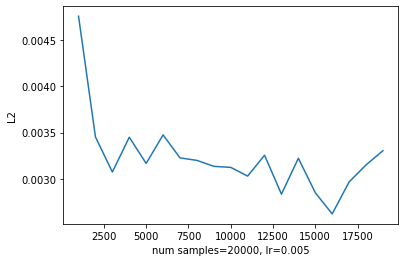

[0.004759098043345148, 0.0034526442034184582, 0.0030725722150987166, 0.003448864801612217, 0.0031658966906979915, 0.003474678588565439, 0.0032258264233823867, 0.003198589802952483, 0.0031340617896130425, 0.0031227291816030628, 0.003028613319096621, 0.0032545023943239357, 0.002832960089820517, 0.0032216828110977077, 0.0028492924582387788, 0.00261901754084829, 0.0029649036990122115, 0.00314895740521024, 0.003303416279872181]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[0.5        0.55555556 0.625      0.71428571 0.83333333 1.
 1.2        1.4        1.6        1.8        2.        ]


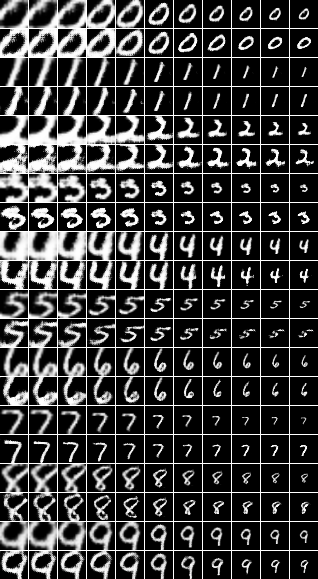

In [16]:
num_samples = 10

a = np.array([1.2, 1.4, 1.6, 1.8, 2.])
np.reciprocal(a[::-1])
b=[np.reciprocal(a[::-1]),np.array([1]),a]
a = np.concatenate(b)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 200
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -0.64, dist 0.02 +/- 0.02
alpha: -0.53, dist 0.03 +/- 0.02
alpha: -0.40, dist 0.03 +/- 0.02
alpha: -0.26, dist 0.04 +/- 0.03
alpha: -0.09, dist 0.04 +/- 0.03
alpha: 0.09, dist 0.03 +/- 0.03
alpha: 0.26, dist 0.02 +/- 0.02
alpha: 0.40, dist 0.01 +/- 0.01
alpha: 0.53, dist 0.01 +/- 0.01
alpha: 0.64, dist 0.00 +/- 0.01
2019-09-12 17:55:27,222 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-12 17:55:27,224 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


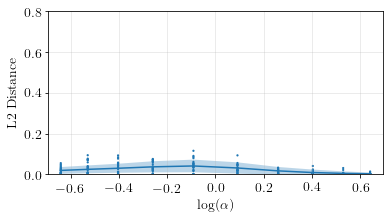

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_aug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_ylim([0, 0.8])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -0.69, dist 0.10 +/- 0.02
alpha: -0.59, dist 0.11 +/- 0.02
alpha: -0.47, dist 0.09 +/- 0.02
alpha: -0.34, dist 0.04 +/- 0.01
alpha: -0.18, dist 0.03 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 0.18, dist 0.02 +/- 0.00
alpha: 0.34, dist 0.03 +/- 0.01
alpha: 0.47, dist 0.04 +/- 0.01
alpha: 0.59, dist 0.06 +/- 0.00
alpha: 0.69, dist 0.08 +/- 0.01


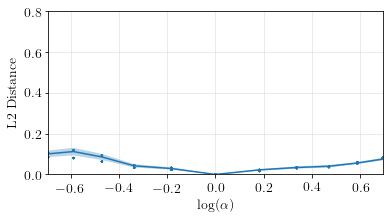

In [22]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_aug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_ylim([0, 0.8])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)